# Final Project

### <span style="color:gray"> Violet Davis and Annie Friar </span>

###
`Data Exploration`

---

In [1]:
# Import libraries

# standard
import pandas as pd
import numpy as np
import random
import os

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from keras.regularizers import l2

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

#silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

random.seed(2)
%matplotlib inline

# FILL IN CODE HERE #
NORMAL_IMAGE_PATH = 'drive/MyDrive/207_final_project/Final_Project_Data/normal/' # Class as 1
GLIOMA_IMAGE_PATH = 'drive/MyDrive/207_final_project/Final_Project_Data/glioma_tumor/' # Class as 2
MENINGIOMA_IMAGE_PATH = 'drive/MyDrive/207_final_project/Final_Project_Data/meningioma_tumor/' # Class as 3
PITUITARY_IMAGE_PATH = 'drive/MyDrive/207_final_project/Final_Project_Data/pituitary_tumor/' # Class as 4

#import drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset


In [2]:
# read image
indx=0
images = []
labels = []

labels_index = 0

print('Sample of normal images in data:')
for idx, img in enumerate(os.listdir(NORMAL_IMAGE_PATH)):
    img = load_img(
    NORMAL_IMAGE_PATH + img)
    images.append(img)
    labels.append((idx, 0))
    labels_index = idx

normal_index = labels_index + 1

for idx, img in enumerate(os.listdir(GLIOMA_IMAGE_PATH)):
    img = load_img(
    GLIOMA_IMAGE_PATH + img)
    images.append(img)
    labels.append((idx+normal_index, 1))
    labels_index = idx

glioma_index = normal_index + labels_index + 1

for idx, img in enumerate(os.listdir(MENINGIOMA_IMAGE_PATH)):
    img = load_img(
    MENINGIOMA_IMAGE_PATH + img)
    images.append(img)
    labels.append((idx+glioma_index, 2))
    labels_index = idx

meningioma_index = glioma_index + labels_index + 1

for idx, img in enumerate(os.listdir(PITUITARY_IMAGE_PATH)):
    img = load_img(
    PITUITARY_IMAGE_PATH + img)
    images.append(img)
    labels.append((idx+meningioma_index, 3))

Sample of normal images in data:


In [3]:
labels = np.array(labels)

In [4]:
labels_df = pd.DataFrame(labels,
                   columns=['img_num', 'Label'])

In [5]:
labels_df['Label'].value_counts()

2    923
1    901
3    844
0    438
Name: Label, dtype: int64

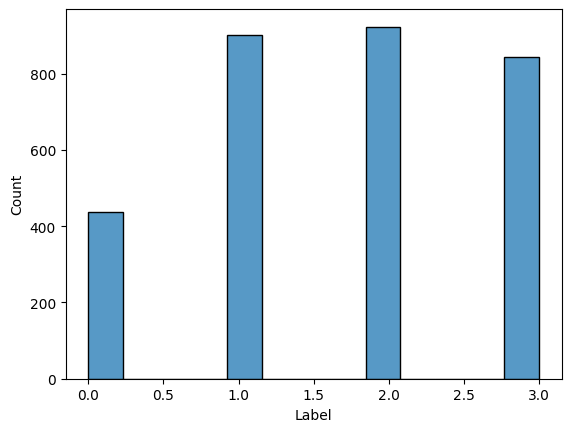

In [6]:
# histogram
sns.histplot(
    data=labels_df,
    stat="count",
    x = "Label"
);

## Split Images Datasets

`Correct for data imbalance`

In [7]:
np.random.seed(1234)

n_size = 438

normal = labels_df[labels_df['Label'] == 0]
glioma = labels_df[labels_df['Label'] == 1]
meningioma = labels_df[labels_df['Label'] == 2]
pituitary = labels_df[labels_df['Label'] == 3]

# randomly draw 400 images from each classes
temp_normal = list(np.random.choice(
    normal.img_num,
    size=n_size,
    replace=False
))

temp_glioma = list(np.random.choice(
    glioma.img_num,
    size=n_size,
    replace=False
))

temp_meningioma = list(np.random.choice(
    meningioma.img_num,
    size=n_size,
    replace=False
))


temp_pituitary = list(np.random.choice(
    pituitary.img_num,
    size=n_size,
    replace=False
))

In [8]:
image_list = []
labels_list = []

for num in temp_normal:
    image_list.append(images[num])
    labels_list.append(labels[num])

for num in temp_glioma:
    image_list.append(images[num])
    labels_list.append(labels[num])

for num in temp_meningioma:
    image_list.append(images[num])
    labels_list.append(labels[num])

for num in temp_pituitary:
    image_list.append(images[num])
    labels_list.append(labels[num])

In [9]:
print("Length of Image List: ", len(image_list))
print("Length of Labels List: ", len(labels_list))

Length of Image List:  1752
Length of Labels List:  1752


In [10]:
images_mini = []
y_mini = []

for img in image_list:

# transform image to array
    img = img_to_array(img)

    # append to images
    images_mini.append(img)

images_mini = np.stack(images_mini)

for label in labels_list:
    y_mini.append(label[1])

y_mini = np.array(y_mini)

In [11]:
images_mini.shape

(1752, 256, 256, 3)

In [12]:
y_mini.shape

(1752,)

## Image Augmentation

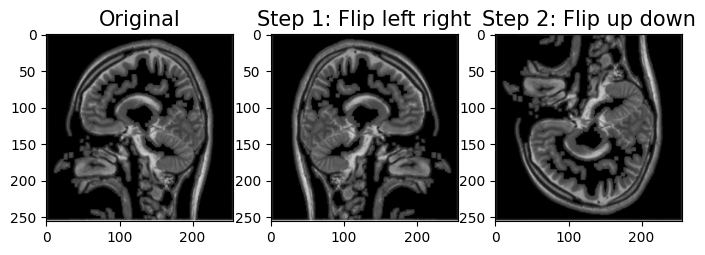

In [18]:
tf.random.set_seed(1234)

fig = plt.figure(figsize=(14, 12))

# pull first image from data
image = images_mini[0]

# plot original
ax = fig.add_subplot(1, 5, 1)
ax.imshow(array_to_img(image))
ax.set_title('Original', size=15);

# flip left right
ax = fig.add_subplot(1, 5, 2)
img_flip = tf.image.flip_left_right(image)
ax.imshow(array_to_img(img_flip))
ax.set_title('Step 1: Flip left right', size=15);

# flip up down
ax = fig.add_subplot(1, 5, 3)
img_flip = tf.image.flip_up_down(image)
ax.imshow(array_to_img(img_flip))
ax.set_title('Step 2: Flip up down', size=15);

# rotate
#ax = fig.add_subplot(1, 5, 4)
#img_rotate = tf.image.rot90(image)
#ax.imshow(array_to_img(img_rotate))
#ax.set_title('Step 3: Rotate', size=15);


In [19]:
def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets

    Params:
    -------
    images  (np.ndarray): Images of shape (N, 256, 256, 1)
    y (np.ndarray): Labels of shape (N,)
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets

    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 256, 256, 1)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 256, 256, 1)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 256, 224, 1)
    y_test (np.ndarray): Test labels of shape (N_test,)

    """

    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator
    tf.random.set_seed(1234)
    np.random.seed(1234)

    shuffle = np.random.permutation(np.arange(len(images)))
    images, y = images[shuffle], y[shuffle]

    splits = np.multiply(len(images_mini), split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y, [splits[0], splits[0]+splits[1]])

    # rescale image to [0,1]
    X_train = tf.image.rgb_to_grayscale(X_train)/255.0
    X_val = tf.image.rgb_to_grayscale(X_val)/255.0
    X_test = tf.image.rgb_to_grayscale(X_test)/255.0

    ### image augmentation on training data ###
    ###########################################

    # random flip
    X_train_augm = tf.image.random_flip_left_right(X_train)

    # random flip up
    X_train_augm = tf.image.random_flip_up_down(X_train_augm)

    # random rotate - not working
    #X_train_augm = tf.image.random_rotation(X_train_augm, 90)

    # concatenate original X_train and augmented X_train data
    X_train = tf.concat([X_train, X_train_augm],axis=0)

    # concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm],axis=0)

    # shuffle X_train and y_train, i.e., shuffle two tensors in the same order
    shuffle = tf.random.shuffle(tf.range(tf.shape(X_train)[0], dtype=tf.int32))
    X_train = tf.gather(X_train, shuffle)
    y_train = tf.gather(y_train, shuffle).numpy() #also transforms y_train to numpy array

    return X_train, y_train, X_val, y_val, X_test, y_test

In [21]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini,
    y_mini,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")

X_train shape (2102, 256, 256, 1)
y_train shape (2102,)
X_val shape (350, 256, 256, 1)
y_val shape (350,)
X_test shape (351, 256, 256, 1)
y_test shape (351,)


In [22]:
validate_split = pd.DataFrame(y_train)

In [23]:
validate_split.value_counts()

0    542
3    528
2    518
1    514
dtype: int64

In [24]:
y_train.shape

(2102,)

In [25]:
type(y_train)

numpy.ndarray

In [26]:
y_train_dense = np.copy(y_train)
y_val_dense = np.copy(y_val)
y_test_dense = np.copy(y_test)

In [27]:
type(y_train_dense)

numpy.ndarray

In [28]:
def get_one_hot_labels(dense_labels):

  one_hot_labels = []

  for label in dense_labels:
    if label == 0:
      one_hot_labels.append([1,0,0,0])
    elif label == 1:
      one_hot_labels.append([0,1,0,0])
    elif label == 2:
      one_hot_labels.append([0,0,1,0])
    elif label == 3:
      one_hot_labels.append([0,0,0,1])
    else:
      print(label)
      raise Exception

  one_hot_labels = np.array(one_hot_labels)

  return one_hot_labels

In [29]:
y_train = get_one_hot_labels(y_train)
y_val = get_one_hot_labels(y_val)
y_test = get_one_hot_labels(y_test)

In [30]:
y_train.shape

(2102, 4)

##SVD

In [31]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [32]:
X_train_example = X_train[:1]

In [33]:
def svd_compressor(image, order):
    """Returns the compressed image channel at the specified order"""

    # Create an array filled with zeros having the shape of the image
    compressed = np.zeros(image.shape)

    # Get the U, S and V terms (S = SIGMA)
    U, S, V = np.linalg.svd(image)

    # Loop over U columns (Ui), S diagonal terms (Si) and V rows (Vi) until the chosen order
    for i in range(order):
        Ui = U[:, i].reshape(-1, 1)
        Vi = V[i, :].reshape(1, -1)
        Si = S[i]
        compressed += (Ui * Si * Vi)

    return compressed

In [34]:
for img in X_train_example:
  img = array_to_img(img)
  gray_image = img

100%|██████████| 8/8 [00:00<00:00, 18.08it/s]


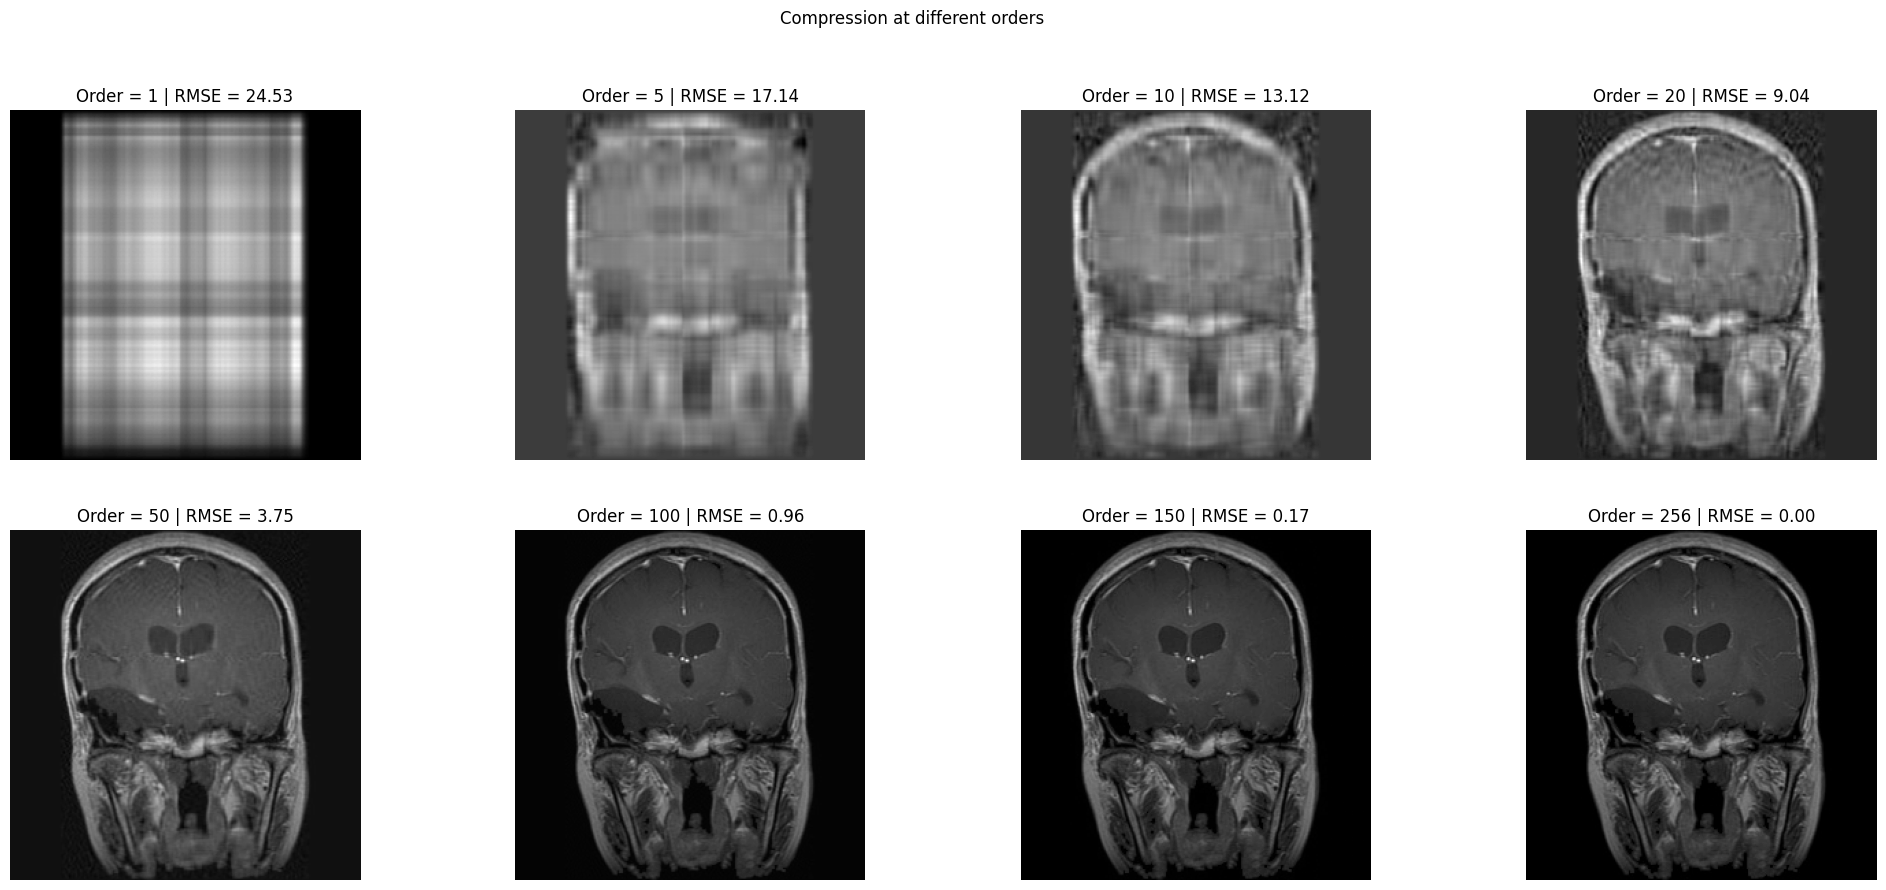

In [35]:
# Convert to Numpy array for the function
gray_image = np.array(gray_image)

orders = [1, 5, 10, 20, 50, 100, 150, 256]
rmse = []

plt.figure(figsize=(25, 10))

for i in tqdm(range(len(orders))):

    # Use the compressor function
    order = orders[i]
    gray_comp = svd_compressor(gray_image, order)

    # Round the calculated values and convert them from float to int.
    gray_comp = np.around(gray_comp).astype(int)

    # Calculate RMSE
    rmse.append(np.sqrt(np.mean((gray_image - gray_comp)**2)))

    # Display the compressed gray image in the subplot
    plt.subplot(2, 4, i + 1)
    plt.title("Order = {} | RMSE = {:.2f}".format(order, rmse[i]))
    plt.axis('off')
    plt.imshow(gray_comp, cmap='gray')

plt.suptitle('Compression at different orders')
plt.show()

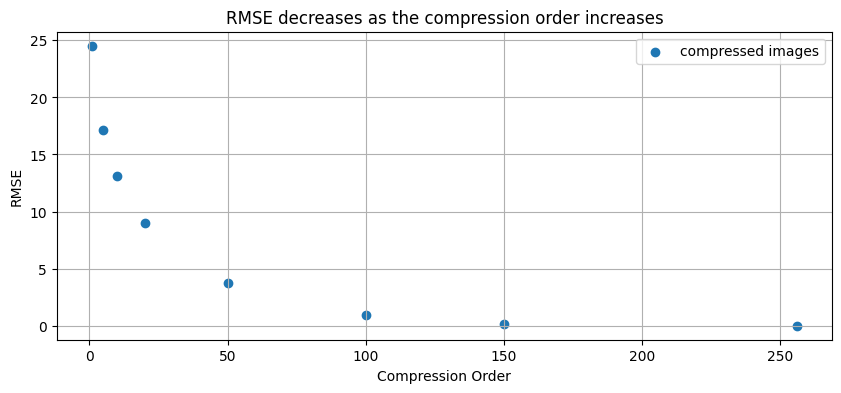

In [36]:
def f(x, a, b, c, d):
    return a * np.log(b * x + c) + d

x_fit = np.linspace(orders[0], orders[-1], 100)
params = curve_fit(f, orders, rmse, bounds=(0,40))
y_fit = f(x_fit, *params[0])

plt.figure(figsize=(10, 4))
plt.scatter(orders, rmse, label="compressed images")
#plt.plot(x_fit, y_fit, c='r', ls='-', label="fit")
plt.title("RMSE decreases as the compression order increases")
plt.xlabel("Compression Order")
plt.ylabel("RMSE")
plt.grid('on')
plt.legend()
plt.show()

In [37]:
def svd_compress_image_data(images_array):
  comp_images_array = []

  compress_to = 50

  for img in images_array:
    img = array_to_img(img)
    gray_image = img

    gray_image = np.array(gray_image)

    gray_comp = svd_compressor(gray_image, compress_to)

    # Round the calculated values and convert them from float to int.
    gray_comp = np.around(gray_comp).astype(int)

    comp_final = img_to_array(gray_comp)

    comp_images_array.append(comp_final)

  return comp_images_array

In [38]:
def apply_svd(X_dataset):
  data = X_dataset
  data_compressed = svd_compress_image_data(data)

  images_svd = []

  for img in data_compressed:
    # transform image to array
    img = img_to_array(img)

    # append to images
    images_svd.append(img)

  images_svd = np.stack(images_svd)

  return images_svd

In [39]:
X_train_svd = apply_svd(X_train)

In [40]:
X_val_svd = apply_svd(X_val)

In [41]:
X_test_svd = apply_svd(X_test)

## Build CNN

In [42]:
def build_CNN_model():
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  images = tf.keras.layers.Input(shape=(256, 256, 1), dtype=tf.float32, name='Images')

  features = tf.keras.layers.Add()(
      [images])

  conv_1 = tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=5,
    strides=1,
    #kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'
      )(features)

  b1 = layers.BatchNormalization()(conv_1)

  pool_1 = tf.keras.layers.MaxPool2D(
    pool_size=2,
    name='pool_1')(b1)

  conv_2 = tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=5,
    strides=1,
    #kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
    padding='same',
    name='conv_2',
    activation='relu')(pool_1)

  b2 = layers.BatchNormalization()(conv_2)

  pool_2 = tf.keras.layers.MaxPool2D(
    pool_size=2, name='pool_2')(b2)

  conv_3 = tf.keras.layers.Conv2D(
    filters=128,
    kernel_size=5,
    strides=1,
    #kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),
    padding='same',
    name='conv_3',
    activation='relu')(pool_2)

  b3 = layers.BatchNormalization()(conv_3)

  pool_3 = tf.keras.layers.MaxPool2D(
    pool_size=2, name='pool_3')(b3)

  flat = tf.keras.layers.Flatten()(pool_3)

  dense = tf.keras.layers.Dense(
    units=1024,
    name='dense',
    activation='relu')(flat)

  drop = tf.keras.layers.Dropout(
    rate=0.5)(dense)

  preds = tf.keras.layers.Dense(
      units=4, activation='softmax', name='Predictions')(drop)

  model = tf.keras.Model(inputs=[images],
                         outputs=preds,
                         name='CNN')
  model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      loss="sparse_categorical_crossentropy",
      metrics=['accuracy'])

  return model

In [43]:
model_cnn = build_CNN_model()

history = model_cnn.fit(
  x={
      'Images': X_train_svd
    },
  y=y_train_dense,
  epochs=25,
  #batch_size=16,
  validation_data=(
      {
        'Images': X_val_svd
      },
      y_val_dense)
)

Epoch 1/25
66/66 [==============================] - 22s 164ms/step - loss: 30.6155 - accuracy: 0.5062 - val_loss: 162.2428 - val_accuracy: 0.2429
Epoch 2/25
66/66 [==============================] - 9s 133ms/step - loss: 3.0530 - accuracy: 0.5371 - val_loss: 13.7507 - val_accuracy: 0.3543
Epoch 3/25
66/66 [==============================] - 8s 124ms/step - loss: 1.4963 - accuracy: 0.5766 - val_loss: 3.1064 - val_accuracy: 0.5229
Epoch 4/25
66/66 [==============================] - 8s 127ms/step - loss: 1.7196 - accuracy: 0.5913 - val_loss: 3.8376 - val_accuracy: 0.6000
Epoch 5/25
66/66 [==============================] - 9s 129ms/step - loss: 1.1673 - accuracy: 0.5937 - val_loss: 1.7268 - val_accuracy: 0.6886
Epoch 6/25
66/66 [==============================] - 8s 126ms/step - loss: 1.1923 - accuracy: 0.6204 - val_loss: 2.2570 - val_accuracy: 0.6343
Epoch 7/25
66/66 [==============================] - 8s 126ms/step - loss: 1.7677 - accuracy: 0.5833 - val_loss: 1.4003 - val_accuracy: 0.6686
E

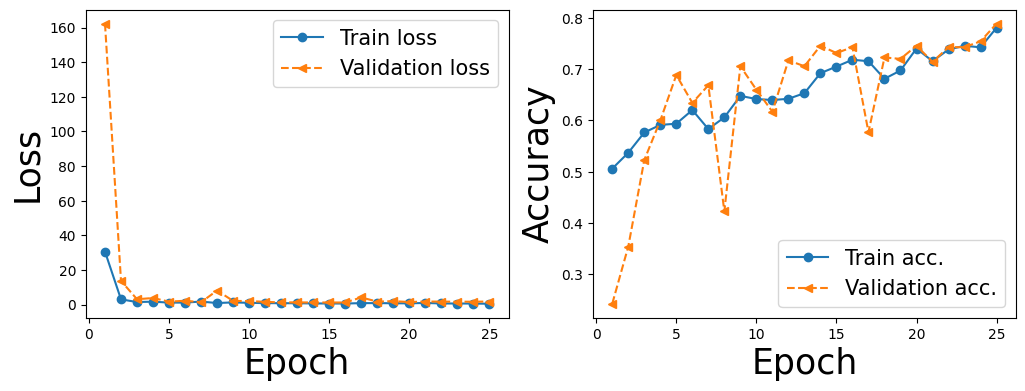

In [44]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=25)
ax.set_ylabel('Loss', size=25)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=25)
ax.set_ylabel('Accuracy', size=25)
plt.show()

## Analyze Results

In [47]:
val_results = model_cnn.evaluate(X_val_svd, y_val_dense)
print('\nVal Acc. {:.2f}%'.format(val_results[1]*100))

11/11 [==============================] - 0s 40ms/step - loss: 1.7981 - accuracy: 0.7886

Val Acc. 78.86%


In [49]:
pred_labels = model_cnn.predict(X_val_svd)

11/11 [==============================] - 1s 41ms/step


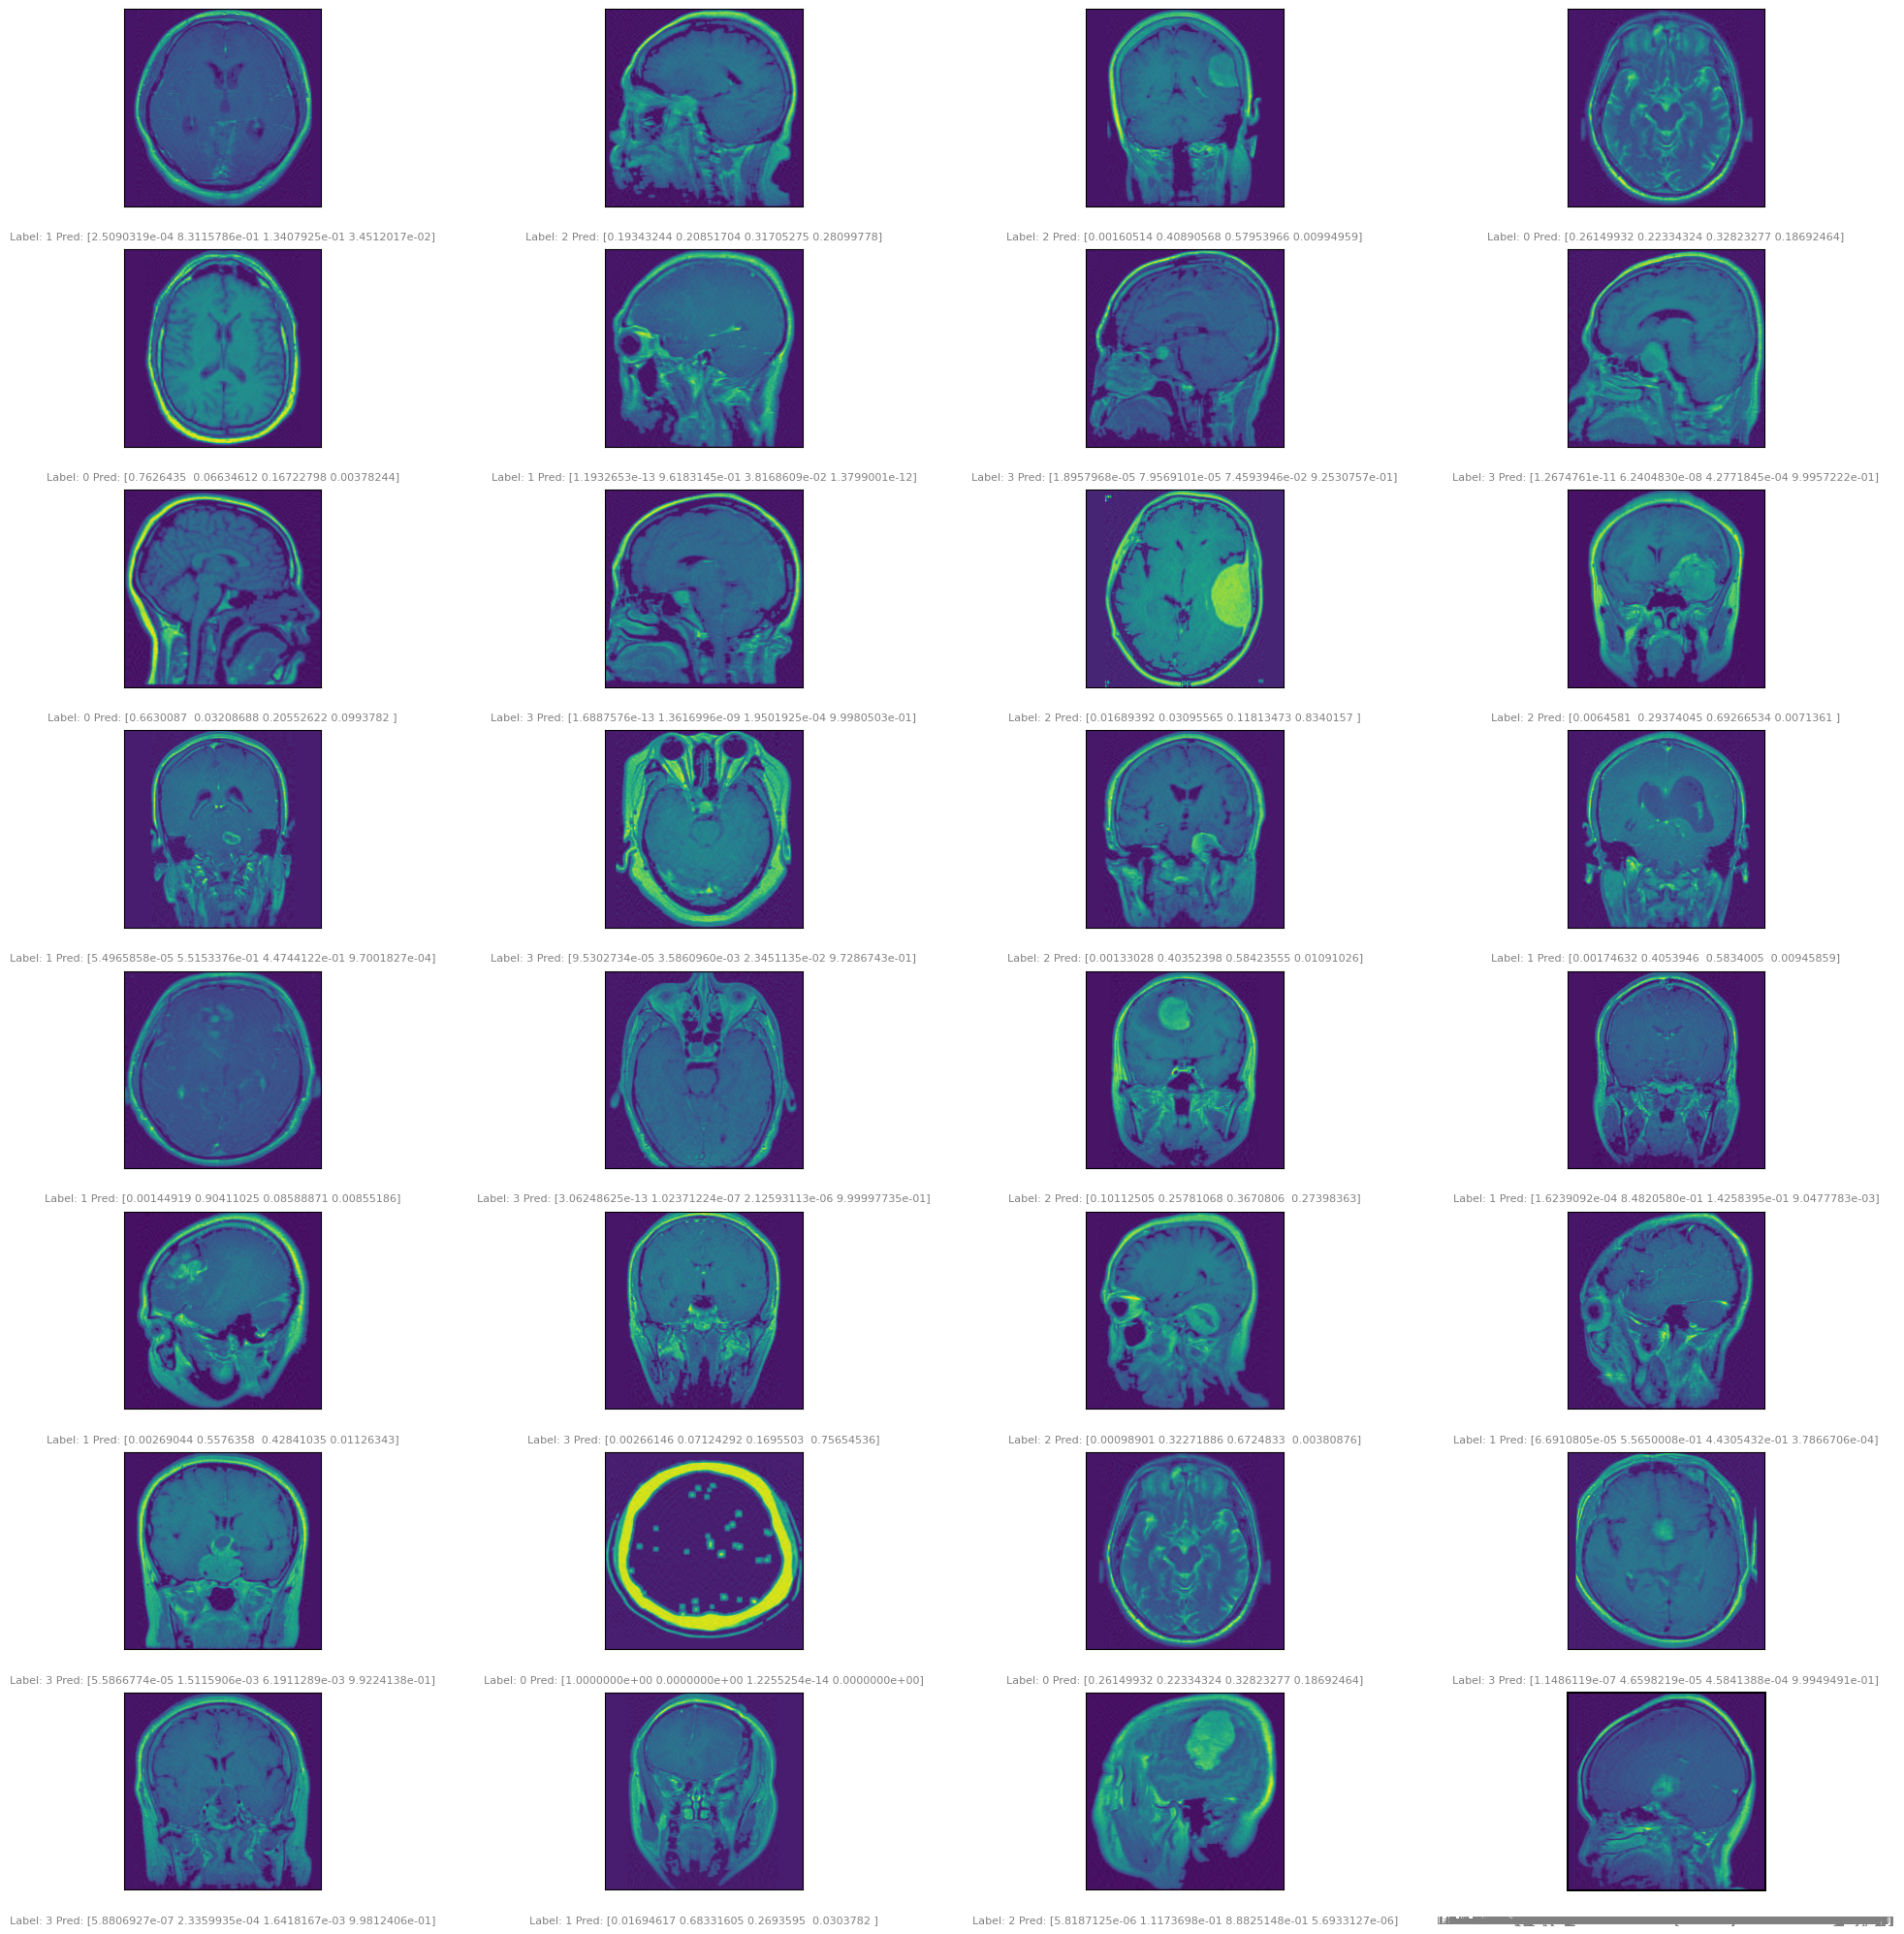

In [54]:
# plot test data and associated predicred
fig = plt.figure(figsize=(20, 20))

for j, example in enumerate(X_val_svd):
    ax = fig.add_subplot(8,4, min(j+1, 32))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(array_to_img(example))
    label = str(y_val_dense[j])


    ax.text(
        0.5, -0.15,
        'Label: {:s} Pred: {:s}'.format(label, str(pred_labels[j])),
        size=8,
        color='grey',
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes)

plt.tight_layout()
plt.show()

In [55]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val_dense, pred_labels)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

InvalidArgumentError: ignored